In [19]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
def get_CIFAR_splits(split=0.8, n_classes=10):
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
    
    train_data = datasets.CIFAR10(
        root = 'data',
        train = True,                         
        transform = transform,
        download = True,            
    )
    test_data = datasets.CIFAR10(
        root = 'data', 
        train = False, 
        transform = transform,
        download = True,
    )
    
    print(f'number of train data points: {len(train_data)}')
    print(f'number of test data points: {len(test_data)}')
    
    idx = np.array(train_data.targets) <= n_classes - 1
    train_data.data = train_data.data[idx]
    train_data.targets = list(np.array(train_data.targets)[idx])
    
    idx = np.array(test_data.targets) <= n_classes - 1
    test_data.data = test_data.data[idx]
    test_data.targets = list(np.array(test_data.targets)[idx])
    
    merged = torch.utils.data.ConcatDataset([train_data, test_data])
    n_train = int(len(merged) * split)
    n_test = len(merged) - n_train
    train_data, test_data = torch.utils.data.random_split(merged, [n_train, n_test], generator=torch.Generator().manual_seed(42))
    
    print(f'number of train data points: {len(train_data)}')
    print(f'number of test data points: {len(test_data)}')

    return train_data, test_data

In [30]:
def get_loaders(train_data, test_data, shuffle=True, nw=4):
    loaders = {
        'train' : torch.utils.data.DataLoader(train_data, 
                                              batch_size=512, 
                                              shuffle=shuffle, 
                                              num_workers=nw),
        
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=512, 
                                              shuffle=True, 
                                              num_workers=nw),
    }
    return loaders

In [22]:
class LeNet(nn.Module):
    def __init__(self, in_features=3, num_classes=10):
        super(LeNet, self).__init__()
        self.conv_block = nn.Sequential( nn.Conv2d(in_channels=in_features,
                                                   out_channels=6,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2,2),
                                         
                                         nn.Conv2d(in_channels=6,
                                                   out_channels=16,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2,2)
                                        )
        
        self.linear_block = nn.Sequential( nn.Linear(16*5*5, 120),
                                           nn.Tanh(),
                                           nn.Linear(120,84),
                                           nn.Tanh(),
                                           nn.Linear(84,10)
                                         )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [23]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

def train(num_epochs, cnn, loaders):
    losses = []
    test_accs = []
    total_step = len(loaders['train'])
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(loaders['train']):
            cnn.train()
            images = images.to(device)
            labels = labels.to(device)

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()          
            epoch_loss += loss.item()

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss))
        losses.append(epoch_loss)
        test_accs.append(test())
    
    return losses, test_accs

def test():
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = len(test_data)
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            output = cnn(images)
            pred_y = torch.argmax(output, dim=1)
            correct += (pred_y == labels).sum().item()
    accuracy = correct / total
    #print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}')
    return accuracy

In [27]:
def plot_learning(losses, test_accs):
    plt.figure()
    plt.plot(losses, label='training loss')
    plt.show()
    
    plt.figure()
    plt.plot(test_accs, label='testing accuracy')
    plt.show()

#### Train LeNet5s on CIFAR100. Shows how OOM more data improves test accuracy:

Files already downloaded and verified
Files already downloaded and verified
number of train data points: 50000
number of test data points: 10000
number of train data points: 1500
number of test data points: 58500
Epoch [1/30], Loss: 1068.2462
Epoch [2/30], Loss: 1012.1652
Epoch [3/30], Loss: 960.7966
Epoch [4/30], Loss: 884.9193
Epoch [5/30], Loss: 865.7425
Epoch [6/30], Loss: 821.8972
Epoch [7/30], Loss: 777.8229
Epoch [8/30], Loss: 721.6729
Epoch [9/30], Loss: 661.4177
Epoch [10/30], Loss: 603.9103
Epoch [11/30], Loss: 578.9830
Epoch [12/30], Loss: 526.1024
Epoch [13/30], Loss: 494.3025
Epoch [14/30], Loss: 426.0093
Epoch [15/30], Loss: 432.7584
Epoch [16/30], Loss: 394.9743
Epoch [17/30], Loss: 299.3670
Epoch [18/30], Loss: 257.6346
Epoch [19/30], Loss: 192.6094
Epoch [20/30], Loss: 177.8080
Epoch [21/30], Loss: 141.3164
Epoch [22/30], Loss: 89.0958
Epoch [23/30], Loss: 58.7802
Epoch [24/30], Loss: 40.3317
Epoch [25/30], Loss: 34.0338
Epoch [26/30], Loss: 20.2042
Epoch [27/30], Loss

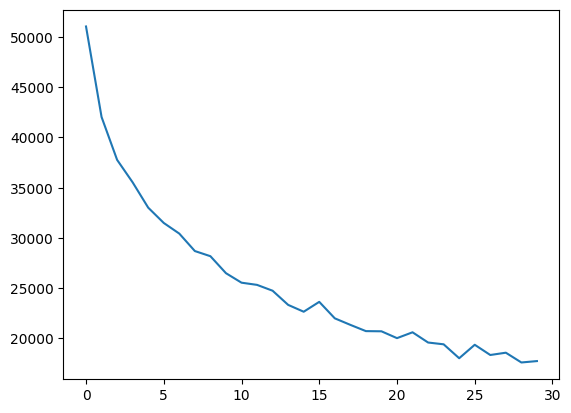

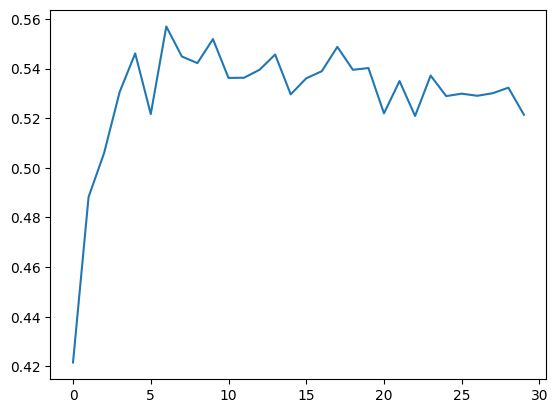

In [31]:
num_epochs = 30
splits = list(np.arange(0.025, 0.5, 0.025))
split_accs = []

for split in splits: 
    train_data, test_data = get_CIFAR_splits(split, n_classes=10)
    loaders = get_loaders(train_data, test_data)
    cnn = LeNet().to(device)
    losses, test_accs = train(num_epochs, cnn, loaders)
    best_acc = max(test_accs)
    print(f'best test accuracy after {num_epochs} epochs: {best_acc}')
    split_accs.append(best_acc)

# look at how the last model's training went:
plot_learning(losses, test_accs)

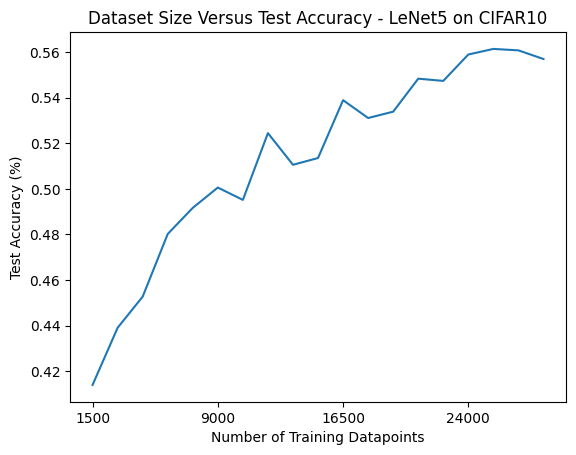

In [55]:
plt.figure()
plt.plot(split_accs)
plt.title('Dataset Size Versus Test Accuracy - LeNet5 on CIFAR10')
data_sizes = list(range(1,len(split_accs)+1,5))
data_sizes = [x * 1500 for x in data_sizes]
plt.xticks(range(0,len(split_accs),5), data_sizes)
plt.xlabel("Number of Training Datapoints")
plt.ylabel("Test Accuracy (%)")
plt.show()

#### LeNet5s on CIFAR100. Increasing the number of classes (i.e. generating distributions / functions) decreases test accuracy:

Files already downloaded and verified
Files already downloaded and verified
number of train data points: 50000
number of test data points: 10000
number of train data points: 3000
number of test data points: 9000
Epoch [1/25], Loss: 282.0681
Epoch [2/25], Loss: 220.6189
Epoch [3/25], Loss: 232.3050
Epoch [4/25], Loss: 202.9970
Epoch [5/25], Loss: 200.4264
Epoch [6/25], Loss: 167.5983
Epoch [7/25], Loss: 164.3725
Epoch [8/25], Loss: 135.4058
Epoch [9/25], Loss: 153.0472
Epoch [10/25], Loss: 116.5938
Epoch [11/25], Loss: 107.5765
Epoch [12/25], Loss: 112.1313
Epoch [13/25], Loss: 112.7968
Epoch [14/25], Loss: 85.7682
Epoch [15/25], Loss: 110.6171
Epoch [16/25], Loss: 69.0552
Epoch [17/25], Loss: 74.9722
Epoch [18/25], Loss: 67.5433
Epoch [19/25], Loss: 62.0857
Epoch [20/25], Loss: 82.7286
Epoch [21/25], Loss: 49.8963
Epoch [22/25], Loss: 24.5573
Epoch [23/25], Loss: 25.8211
Epoch [24/25], Loss: 26.9712
Epoch [25/25], Loss: 20.9966
best test accuracy after 25 epochs: 0.8864444444444445
Fil

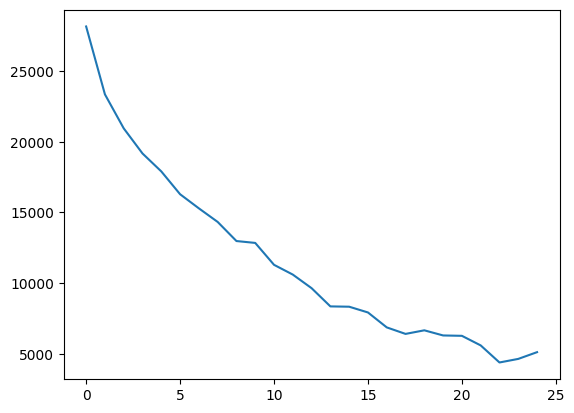

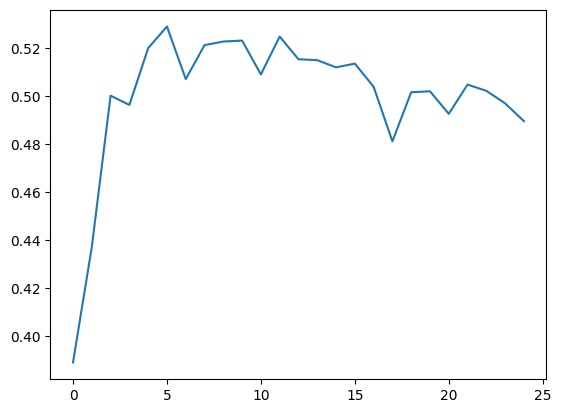

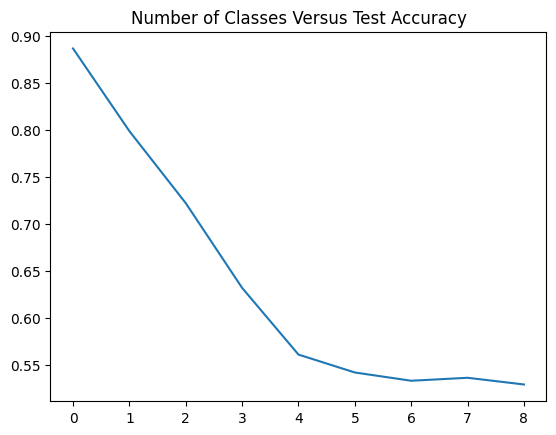

In [35]:
num_epochs = 25
n_classes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
n_class_accs = []

for n_class in n_classes: 
    train_data, test_data = get_CIFAR_splits(0.25, n_classes=n_class)
    loaders = get_loaders(train_data, test_data)
    cnn = LeNet().to(device)
    losses, test_accs = train(num_epochs, cnn, loaders)
    best_acc = max(test_accs)
    print(f'best test accuracy after {num_epochs} epochs: {best_acc}')
    n_class_accs.append(best_acc)

# look at how the last model's training went:
plot_learning(losses, test_accs)

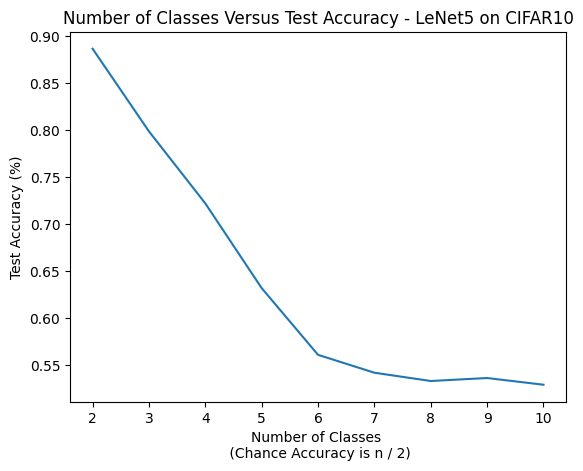

In [63]:
plt.figure()
plt.plot(n_class_accs)
plt.title('Number of Classes Versus Test Accuracy - LeNet5 on CIFAR10')
plt.xlabel('Number of Classes \n (Chance Accuracy is n / 2)')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(len(n_class_accs)), range(2,11))
plt.show()